# Construisez un modèle de scoring
Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

Pour accorder un crédit à la consommation, l’entreprise calcule la probabilité qu’un client le rembourse, ou non. Elle souhaite donc développer un algorithme de scoring pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs du modèle de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un client.


# Feature selection
Nous allons procéder à une sélection des variables les plus intéressantes avec l'algorithme **SelecKbest**.
L'algorithme **SelectKBest** va nous permettre de rechercher dans l'ensemble de données celles qui présente une variance élevée. Une variance élevée va augmenter nos chances de faire de bonnes prédictions. 
Cependant nous allons utiliser toutes les données afin de faire un classement par ordre d'importance. Cela nous permettra d'entrainer un modèle en ajoutant à chaque fois une nouvelle variables.

Avant de procéder à la sélection des variables il est nécéssaire de préparer celle-ci, tel que nous l'avons vu lors de l'analyse des données : 
 - Suppression des valeurs aberrantes
 - Création des nouvelles variables
 - Suppression des corrélations de plus de 90% en ne gardant que celle qui possèdent le mois de valeurs manquantes.
 - Suppression la variable  **SK_ID_CURR** qui est l'identifiant de la transaction et donc qui n'est pas nécessaire pour les prédictions
 - Extraction de la variable **TARGET** qui est la valeur à prédire. 
 - Dans l'analyse précédente nous avons trouvé que certaines variables devaient être crée.
 - Nous allons transfomer les variables binaires qui sont au format Yes/Non en 0/1
 - Pour les variables qualitaives nous allons créer une nouvele colonne 'Missing' pour les valeurs manquantes et les transformer en encodage 1 parmi n
 - Pour les variables quantitatives nous allons remplacer les valeurs manquantes par la médiane des données.
 - Les données vont êtres standardisées 


In [1]:
import numpy as np
import pandas as pd
from typing import List
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE    

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [4]:
#base_directory = "/kaggle/input/home-credit-default-risk/"
base_directory = "../data/home-credit-default-risk/"

In [5]:
def delete_correlation(df,threshold): 
    """
    Teste la corrélation entre toutes les variabes du dataset et si la corrélation
    est supérieure à la valeur de threshold, la variable ayant les plus de valeur
    manquantes est supprimée.
    """
    corr_list = []
    corr = df.corr()
    for i in range(len(corr)):
        for j in range(i):
           
            if corr.iloc[i,j] >= threshold:
                
                #print(f"{corr.iloc[i,j] * 100:.2f} de corrélation entre {corr.columns[i]} et {corr.columns[j]}")
                
                if corr.columns[j] in df.columns and corr.columns[j] in df.columns:                            
                    A = df[corr.columns[i]].isna().sum()
                    B = df[corr.columns[j]].isna().sum()
                    if A <= B:
                        df.drop(corr.columns[j], axis=1, inplace=True)
                    else:
                        df.drop(corr.columns[i], axis=1, inplace=True)
    return df

In [6]:
def getScore(elem):
    return elem[1]

In [7]:
def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('object')
        else:
            df[col] = pd.to_datetime(df[col])
    return df



def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))


def optimized_merge(df1, df2, merge_column):    
    df2 = df2[df2[merge_column].isin(df1[merge_column])]
    df2 = df2.sample(frac=.20)
    return df1.merge(df2, how= 'left', on=merge_column)


## Chargement des données

In [8]:
# Chargement des données
application_train = pd.read_csv(base_directory + 'application_train.csv')

# Optimisation des variables pour réduire l'empreinte mémoire
application_train = optimize(application_train)
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.500,29686.500,...,0,0,0,0,nan,nan,nan,nan,nan,nan
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.000,21865.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000


## Valeurs aberrantes

In [9]:
application_train = application_train.drop(index=application_train.loc[application_train['AMT_INCOME_TOTAL'] == 117000000].index)

## Création des nouvelles variables

In [10]:
application_train['YEARS_BIRTH'] = abs(application_train['DAYS_BIRTH']) / 365.25
application_train = application_train.drop('DAYS_BIRTH', axis=1)

application_train['DAYS_EMPLOYED']  = application_train['DAYS_EMPLOYED'].replace([365243],np.NaN)   
application_train['YEARS_EMPLOYED'] = abs(application_train['DAYS_EMPLOYED']) / 365.25
application_train = application_train.drop('DAYS_EMPLOYED', axis=1)

application_train['YEARS_REGISTRATION'] = abs(application_train['DAYS_REGISTRATION']) / 365.25
application_train = application_train.drop('DAYS_REGISTRATION', axis=1)

application_train['YEARS_ID_PUBLISH'] = abs(application_train['DAYS_ID_PUBLISH']) / 365.25
application_train = application_train.drop('DAYS_ID_PUBLISH', axis=1)


In [11]:
application_train['PAYMENT_RATE'] = (application_train['AMT_ANNUITY'] / application_train['AMT_CREDIT']) * 100
application_train['INCOME_CREDIT_RATE'] = (application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']) * 100
application_train['ANNUITY_INCOME_RATE'] = (application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']) * 100
application_train['INCOME_PER_PERSON'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']

## Transformation de variables

In [12]:
application_train['AMT_INCOME_TOTAL_LOG'] = np.log(application_train['AMT_INCOME_TOTAL'])

## Suppression des variables qui ont plus de 90% de corrélation 

In [13]:
application_train = delete_correlation(application_train, 0.9)

## Séparation des variables explicatives et de la variable à prédire et suppression de SK_ID_CURR

In [14]:
target = application_train['TARGET']
application_train = application_train.drop(['TARGET','SK_ID_CURR'], axis=1)

## Imputation des variables binaires

In [15]:
le = preprocessing.LabelEncoder()
application_train['FLAG_OWN_CAR'] = le.fit_transform(application_train['FLAG_OWN_CAR'])
application_train['FLAG_OWN_REALTY'] = le.fit_transform(application_train['FLAG_OWN_REALTY'])

## Imputation des variable qualitatives

In [16]:
application_train['CODE_GENDER']  = application_train['CODE_GENDER'].replace('XNA',np.NaN)    

In [17]:
for obj in application_train.select_dtypes(exclude=[np.number]).columns:    
    application_train[obj] = application_train[obj].fillna('Missing')

application_train = pd.get_dummies(application_train, drop_first=False)    

## Imputation des variables quantitatives avec la médiane

In [18]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

for num in application_train.select_dtypes(include=['number']).columns:
    application_train[num] = application_train[num].fillna(application_train[num].median())

## Normalisation des données

In [19]:
scaler = StandardScaler()
scaler.fit(application_train)
X_train = scaler.transform(application_train)

## Classement des variables expliquatives

In [20]:
feat_list = []
cols = application_train.columns
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train, target)

idxs_selected = fs.get_support(indices=True)
for i in idxs_selected:
    feat_list.append([cols[i],fs.scores_[i]])   
    
feat_list.sort(key=getScore,reverse=True)
for i in feat_list:
    print(i)
    

['EXT_SOURCE_2', 8107.639122074546]
['EXT_SOURCE_3', 7657.3277506918175]
['EXT_SOURCE_1', 3036.5826112159425]
['YEARS_BIRTH', 1893.625145120539]
['YEARS_EMPLOYED', 1239.5608557808469]
['REGION_RATING_CLIENT_W_CITY', 1144.5261968911693]
['NAME_INCOME_TYPE_Working', 1019.064298035284]
['NAME_EDUCATION_TYPE_Higher education', 987.8483672441569]
['DAYS_LAST_PHONE_CHANGE', 940.07821365642]
['CODE_GENDER_M', 923.5856081320018]
['CODE_GENDER_F', 923.2934872759644]
['YEARS_ID_PUBLISH', 816.574732312459]
['REG_CITY_NOT_WORK_CITY', 801.9594469060363]
['NAME_EDUCATION_TYPE_Secondary / secondary special', 765.0723792632053]
['NAME_INCOME_TYPE_Pensioner', 657.9083748971163]
['ORGANIZATION_TYPE_XNA', 651.5782294801165]
['FLAG_EMP_PHONE', 651.4402273608919]
['REG_CITY_NOT_LIVE_CITY', 607.3899000823561]
['FLAG_DOCUMENT_3', 605.7676754612307]
['OCCUPATION_TYPE_Laborers', 569.5454635684054]
['EMERGENCYSTATE_MODE_No', 548.9324711938636]
['YEARS_REGISTRATION', 542.9151699750465]
['EMERGENCYSTATE_MODE_Miss

# Préparation des prédictions
Les données sont déséquilibrées car il y a un nombre élevé de clients qui remboursent le prêt par rapport aux clients qui ne le font pas. Pour éviter que le modèle ne tienne compte que des cas où les clients rembourse,
nous allons devoir rééquilibrer les données. Nous allons essayer deux type de répartission :
  - En prenant toutes les données de client qui ne remboursement pas (24825) et 1,5 fois plus de données (37238) où les clients remboursent.
  - En utilisant un système d'augmentation de données **S**ynthetic **M**inority **O**ver-Sampling **T**Echnique (SMOTE) afin de garder un jeu de données conséquent.


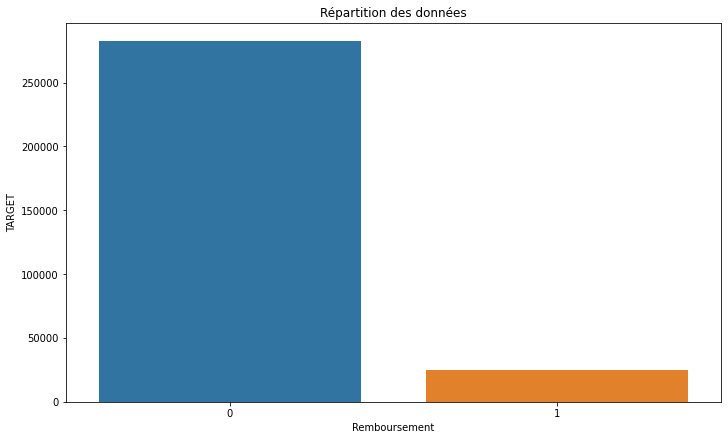

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)
ax.set(xlabel="Remboursement", ylabel='Total', title='Répartition des données') 
sns.barplot(x=target.value_counts().index, y=target.value_counts());
plt.show()

In [22]:
print(f"{(target == 1).sum()} clients qui ne rembourse pas leur crédit")
print(f"{(target == 0).sum()} clients qui rembourse leur crédit")

24824 clients qui ne rembourse pas leur crédit
282686 clients qui rembourse leur crédit


## Partage équitable entre TARGET == 1 et TRAGET == 0

In [23]:
def equiTarget(df, target):    
    rus = RandomUnderSampler(random_state=42)
    train, target = rus.fit_resample(df, target)    
    return train, target

### Smote


In [24]:
def smote(df, target):    
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    train, target = smote.fit_sample(df, target)        
    return train, target

In [25]:
def sample(df, target, frac):
    df['TARGET'] = target
    df = df.sample(frac=frac, random_state=42)
    target = df['TARGET']
    df = df.drop('TARGET', axis=1)
    return  df, target

# Évaluation de scoring
La problématique de la société "Prêt à dépenser" est d'identifier les clients ayant un fort risque de ne pas rembourser, car ceux-ci représentent un coût pour la société et elle ne doit pas refuser les clients succestibles de rembourser. Il faut donc identifier les clients qui vont faire perdre de l'argent à la société et ceux qui vont en faire gagner.

|                 | Prédit non solvable| Prédit solvable |
|:----------------|:-------------------|:----------------|
|**Non solvable** | Vrai positif       | faux négatif    |
|**Solvable**     | faux positif       | vrai négatif    |

Le modèle utilisé devra éviter les **faux négatifs**, c'est à dire prédire que le client est solvable alors qu'il ne l'ai pas. cela fait perdre de l'argenty à la société. Il devra aussi éviter les **faux positifs**, c'est à dire que le clinet n'est pas solvable alors qu'il est.


Nous utiliserons une courbe ROC (receiver operating characteristic) qui représente les performances du modèle pour tous les seuils de classification. Cette courbe trace le taux de vrais positifs en fonction du taux de faux positifs :

 - Le taux de vrais positifs (TVP) qui est l'équivalent du rappel. Il est donc défini comme suit : 
   - $TVP = \frac{VP}{VP + FN}$
 
 - Le taux de faux positifs (TFP) est défini comme suit :
  - $TFP = \frac{FP}{FP + VN}$

Une courbe ROC trace les valeurs TVP et TFP pour différents seuils de classification. Diminuer la valeur du seuil de classification permet de classer plus d'éléments comme positifs, ce qui augmente le nombre de faux positifs et de vrais positifs.



# Modèles
Test de differents modèle.

Tout d'abord nous allons utiliser le modèle Naïve Bayse comme base de travail avec notre jeu de données afin de déterminer le plus efficient. Pour chaque modèle nous testerons les variables afin de déterminer le nombre de variables optimales.

Nous testerons ensuite des modèles linéaires : 
 - LogisticRegression
 - SGDClassifier

et non linéaire :
 - XGBRegressor
 - Random Forest


In [26]:
def plot_roc_curve(fpr, tpr):
    """
    Affichage de la courbe ROC
    """
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrai positifs')
    plt.title('courbe Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.show()


In [27]:
def test_model(model,feat_list,data,target):
    """
    Test un model donné
    """
    
    score_max = 0
    nb_feature = 0
    score_list = []
    columns = []
    count = 1
    
    for col in feat_list:
        columns.append(col[0])
        X = data[columns]
    
        X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True) 
    
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)        
        X_test = scaler.transform (X_test)
        
        model.fit(X_train, y_train)
                     
        preds_proba = model.predict_proba(X_test)[:,1]         
        score = roc_auc_score(y_test,preds_proba)
        
        if score > score_max:
            score_max = score
            y = y_test
            y_preds = preds_proba           
            nb_feature = count
        score_list.append(score)
        count += 1
        
    print(f"{nb_feature} est le nombre de variables optimales avec un roc_auc_score {score_max:.2f}")
    
    fpr, tpr, thresholds = roc_curve(y, y_preds)
    #plot_roc_curve(fpr, tpr)
    return (fpr, tpr)
        

## Modèle de base (Naïve Bayse)
La Classification naïve bayésienne est une classification probaliliste simple

### Under-sampling 

In [28]:
nb = GaussianNB()
X,y = equiTarget(application_train, target)
nb_eq_fpr, nb_eq_tpr = test_model(nb,feat_list,X,y)

181 est le nombre de variables optimales avec un roc_auc_score 0.64


### SMOTE

In [29]:
nb = GaussianNB()
X,y = smote(application_train, target)
X,y = sample(X, y, 0.2)
nb_sm_fpr, nb_sm_tpr = test_model(nb, feat_list, X, y)

81 est le nombre de variables optimales avec un roc_auc_score 0.76


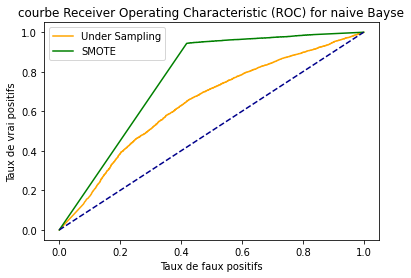

In [30]:
plt.plot(nb_eq_fpr, nb_eq_tpr, color='orange', label='Under Sampling')
plt.plot(nb_sm_fpr, nb_sm_tpr, color='green', label='SMOTE')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrai positifs')
plt.title('courbe Receiver Operating Characteristic (ROC) for naive Bayse')
plt.legend()
plt.show()    

Avec le modèle Naive Bayse, le score est plus élevé avec les données générées avec SMOTE.

# Test des modèles linéaires
Un modèle linéaire est un modèle statistique dans lequel on cherche à exprimer une variable aléatoire Y en fonction de variables explicatives X sous forme d'un opérateur linéaire sur les paramètres inconnus B du modèle.

### Régression Logistique
La régression logistique est une approche statistique qui est utilsée pour évaluer les relations entre une variable cible de type binaire et une ou plusieurs variables explicatives.

In [31]:
lr = LogisticRegression(random_state=42, n_jobs=-1)
X,y = equiTarget(application_train, target)
lr_eq_fpr, lr_eq_tpr = test_model(lr,feat_list,X,y)

116 est le nombre de variables optimales avec un roc_auc_score 0.75


In [32]:
lr = LogisticRegression(random_state=42, n_jobs=-1)
X,y = smote(application_train, target)
X,y = sample(X, y, 0.2)
nb_sm_fpr, nb_sm_tpr = test_model(lr,feat_list,X,y)

113 est le nombre de variables optimales avec un roc_auc_score 0.98


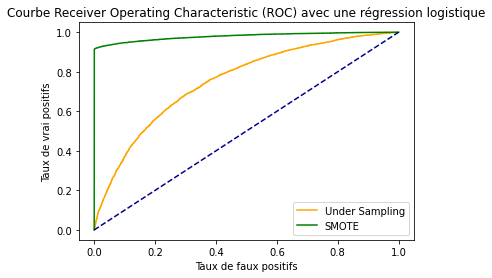

In [33]:
plt.plot(lr_eq_fpr, lr_eq_tpr, color='orange', label='Under Sampling')
plt.plot(nb_sm_fpr, nb_sm_tpr, color='green', label='SMOTE')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrai positifs')
plt.title('Courbe Receiver Operating Characteristic (ROC) avec une régression logistique')
plt.legend()
plt.show()  

### SGDClassifier
La descente de gradient stochastique est un modèle linéaire qui utilise des lots de données pour calculer le gradient à chaque itération. 

In [34]:
sgdc = SGDClassifier(penalty='l2', loss='log', random_state=42, n_jobs=-1)
X,y = equiTarget(application_train, target)
sg_eq_fpr, sg_eq_tpr = test_model(sgdc,feat_list,X,y)

5 est le nombre de variables optimales avec un roc_auc_score 0.73


In [35]:
sgdc = SGDClassifier(penalty='l2', loss='log', random_state=42, n_jobs=-1)
X,y = smote(application_train, target)
X,y = sample(X, y, 0.2)
sg_sm_fpr, sg_sm_tpr = test_model(sgdc,feat_list,X,y)

188 est le nombre de variables optimales avec un roc_auc_score 0.98


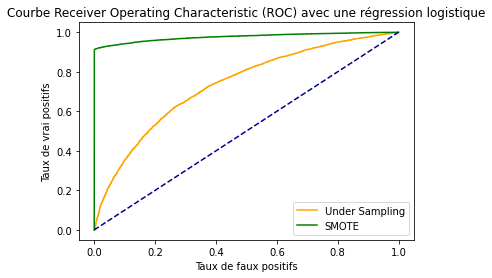

In [36]:
plt.plot(sg_eq_fpr, sg_eq_tpr, color='orange', label='Under Sampling')
plt.plot(sg_sm_fpr, sg_sm_tpr, color='green', label='SMOTE')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrai positifs')
plt.title('Courbe Receiver Operating Characteristic (ROC) avec une régression logistique')
plt.legend()
plt.show()  

Le score du modèle SGDClassifier est moins bon que le modèle de base. Il ne sera donc pas sélectionné.

# Test de modèles non linéaires

### Light Gradient Boosting Mechanism
LightGBM est un algorithme d'amplification des gradients en ajoutant un type de sélection automatique des caractéristiques et en se concentrant sur des exemples d'amplification avec des gradients plus importants. 

Nous utiliserons aussi la fonctionnalité d'entrainement de jeu de données déséquilibré qui existe pour cet algorithme.

In [37]:
lg = LGBMClassifier(random_state=42, n_jobs=-1,is_unbalance=False )
X,y = equiTarget(application_train, target)
lg_eq_fpr, lg_eq_tpr = test_model(lg,feat_list,X,y)

112 est le nombre de variables optimales avec un roc_auc_score 0.77


In [38]:
lg = LGBMClassifier(random_state=42, n_jobs=-1,is_unbalance=False )
X,y = smote(application_train, target)
X,y = sample(X, y, 0.2)
lg_sm_fpr, lg_sm_tpr = test_model(lg,feat_list,X,y)

81 est le nombre de variables optimales avec un roc_auc_score 0.98


In [39]:
lg = LGBMClassifier(random_state=42, n_jobs=-1,is_unbalance=True )
lg_fu_fpr, lg_fu_tpr = test_model(lg,feat_list,application_train,target)

201 est le nombre de variables optimales avec un roc_auc_score 0.77


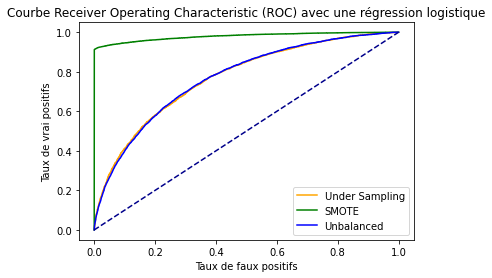

In [40]:
plt.plot(lg_eq_fpr, lg_eq_tpr, color='orange', label='Under Sampling')
plt.plot(lg_sm_fpr, lg_sm_tpr, color='green', label='SMOTE')
plt.plot(lg_fu_fpr, lg_fu_tpr, color='blue', label='Unbalanced')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrai positifs')
plt.title('Courbe Receiver Operating Characteristic (ROC) avec une régression logistique')
plt.legend()
plt.show()  

L'utilisation de SMOTE pour le modèle LightGBM montre clairement un sur apprentissage. En revanche l'utilsation du paramètre unbalanced ou une nombre limité d'observation ont un score assez proche.

## Random Forest
L'algorithme des fôrets aléatoires est constitué d'un ensemble d'arbres de décision indépendants qui seront ensuite assemblés. 

In [41]:
rfc = RandomForestClassifier(random_state=42,n_jobs=-1)
X,y = equiTarget(application_train, target)
rf_eq_fpr, rf_eq_tpr = test_model(rfc,feat_list,X,y)

130 est le nombre de variables optimales avec un roc_auc_score 0.75


In [42]:
rfc = RandomForestClassifier(random_state=42,n_jobs=-1)
X,y = smote(application_train, target)
X,y = sample(X, y, 0.2)
rf_sm_fpr, rf_sm_tpr = test_model(rfc,feat_list,X,y)

79 est le nombre de variables optimales avec un roc_auc_score 0.98


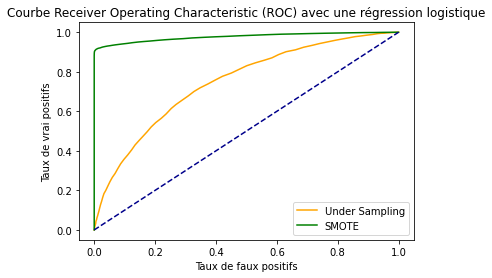

In [43]:
plt.plot(rf_eq_fpr, rf_eq_tpr, color='orange', label='Under Sampling')
plt.plot(rf_sm_fpr, rf_sm_tpr, color='green', label='SMOTE')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrai positifs')
plt.title('Courbe Receiver Operating Characteristic (ROC) avec une régression logistique')
plt.legend()
plt.show()  

# Sauvegarde du dataset

In [46]:
# Sélection des variables explicatives
nb_col = 112
columns = []
for col in feat_list:
    columns.append(col[0])
    nb_col -= 1
    if nb_col <= 0:
        break

df = application_train[columns]
df['TARGET'] = target

In [47]:
df.to_csv(base_directory + "application-clean.csv", index=False)

# Conclusion

Les modèles linéaires ne semblent pas adaptés aux données, les modèles **LightGBM** et **Random Forest** ayant de bien meilleures performances.

Le modèle LightGBM avec 56 paramètres obtient un score de 0.77, il sera donc celui qui sera optimisé.